In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Classifiers
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

#Surrogate models
from skreducedmodel.mksurrogate import mksurrogate

## Fig Final Masses and Final Spin

In [2]:
# Load in the data
path='NS_Simulations_554.dat'
data = pd.read_csv(path)
data = data.astype(float)
data = data.dropna()
data['q']=data['initial_m1']/data['initial_m2']
column1,column2,column3='e','final-mass','q'

In [3]:
data=data.sort_values(column1)
separation_classes=np.unique(round(data['initial-separation'],0).values)
initialm1_classes=np.unique(data[column3].values)

sep0=separation_classes[3] #small separation = separation_classes[3]
sep1=separation_classes[-1]

print('Total number of simulations: ', len(data))
print('initial-sep classes', separation_classes)
print([len(data[round(data['initial-separation'],0)==s0]) for s0 in separation_classes])
sim_by_mass={}
for m1 in initialm1_classes:
    temp=data[round(data[column3],2)==round(m1,2)]
    temp11=temp[round(temp['initial-separation'],0)==11]
    temp246=temp[round(temp['initial-separation'],1)==24.6]
    sim_by_mass.update({str(round(m1,2)):{'num':len(temp),'11':len(temp11),'24.6':len(temp246)}})
    
print('initial-m1 classes',sim_by_mass)

Total number of simulations:  537
initial-sep classes [ 7.  8. 10. 11. 12. 13. 25.]
[3, 7, 3, 200, 4, 2, 318]
initial-m1 classes {'0.01': {'num': 1, '11': 0, '24.6': 0}, '0.02': {'num': 2, '11': 0, '24.6': 0}, '0.03': {'num': 13, '11': 0, '24.6': 9}, '0.07': {'num': 13, '11': 0, '24.6': 9}, '0.1': {'num': 1, '11': 0, '24.6': 0}, '0.14': {'num': 24, '11': 1, '24.6': 23}, '0.17': {'num': 24, '11': 0, '24.6': 23}, '0.2': {'num': 25, '11': 1, '24.6': 23}, '0.25': {'num': 91, '11': 68, '24.6': 23}, '0.33': {'num': 24, '11': 1, '24.6': 23}, '0.4': {'num': 24, '11': 1, '24.6': 23}, '0.41': {'num': 1, '11': 0, '24.6': 0}, '0.5': {'num': 64, '11': 41, '24.6': 23}, '0.55': {'num': 1, '11': 1, '24.6': 0}, '0.6': {'num': 24, '11': 0, '24.6': 23}, '0.67': {'num': 1, '11': 0, '24.6': 0}, '0.7': {'num': 23, '11': 0, '24.6': 23}, '0.75': {'num': 41, '11': 41, '24.6': 0}, '0.8': {'num': 24, '11': 1, '24.6': 23}, '0.85': {'num': 1, '11': 0, '24.6': 0}, '0.9': {'num': 22, '11': 0, '24.6': 22}, '0.93': {'

In [4]:
dense_eccentrity_sims_sep11=[]
dense_eccentrity_sims_sep24=[]
for mass_str,sim in sim_by_mass.items():
    if sim['num']>10:
        fixed_mass_data=data[round(data['q'],2)==float(mass_str)]
        if sim['11']>10:
            fixed_sep_data=fixed_mass_data[round(fixed_mass_data['initial-separation'],0)==11]
            dense_eccentrity_sims_sep11.append(fixed_sep_data)
        elif sim['24.6']>10:
            fixed_sep_data=fixed_mass_data[round(fixed_mass_data['initial-separation'],1)==24.6]
            dense_eccentrity_sims_sep24.append(fixed_sep_data)

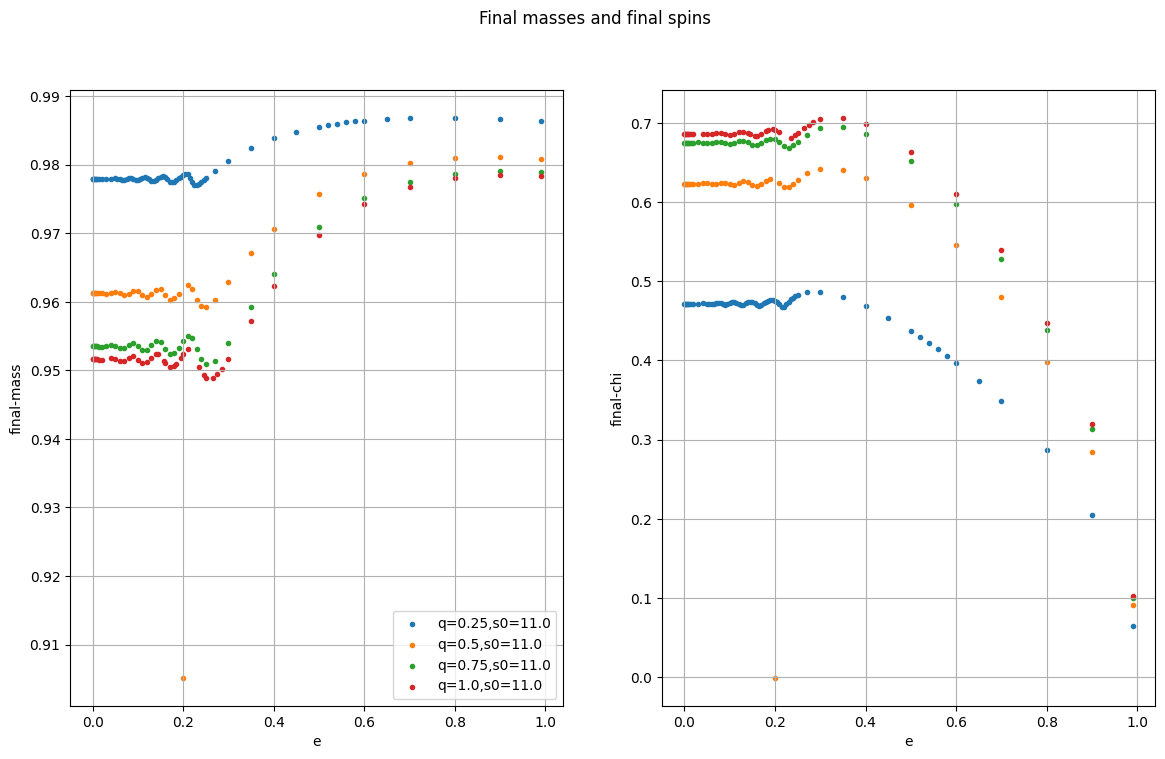

In [18]:
def plot_final_mass_and_spin(x_name='e',y_name='final-mass',z_name='final-chi'):
    fig, axs = plt.subplots(1,2,figsize=(14,8))
    
    for sim in dense_eccentrity_sims_sep11:
        mass_label=str(np.unique(round(sim['q'],2))[0])
        s_label=str(np.unique(round(sim['initial-separation'],0))[0])
        axs[0].scatter(sim[x_name],sim[y_name],marker='.',label='q='+mass_label+',s0='+s_label)
        
    axs[0].set_xlabel(x_name)
    axs[0].set_ylabel(y_name)
    axs[0].grid()
    axs[0].legend(loc='best')
    for sim in dense_eccentrity_sims_sep11:
        mass_label=str(np.unique(round(sim['q'],2))[0])
        s_label=str(np.unique(round(sim['initial-separation'],0))[0])
        axs[1].scatter(sim[x_name],sim[z_name],marker='.',label='q='+mass_label+',s0='+s_label)
    
    axs[1].set_xlabel(x_name)
    axs[1].set_ylabel(z_name)
    axs[1].grid()
    fig.suptitle('Final masses and final spins')
    plt.savefig('final_mass-final_spin_vs_e_sep11.png')
    return

plot_final_mass_and_spin()

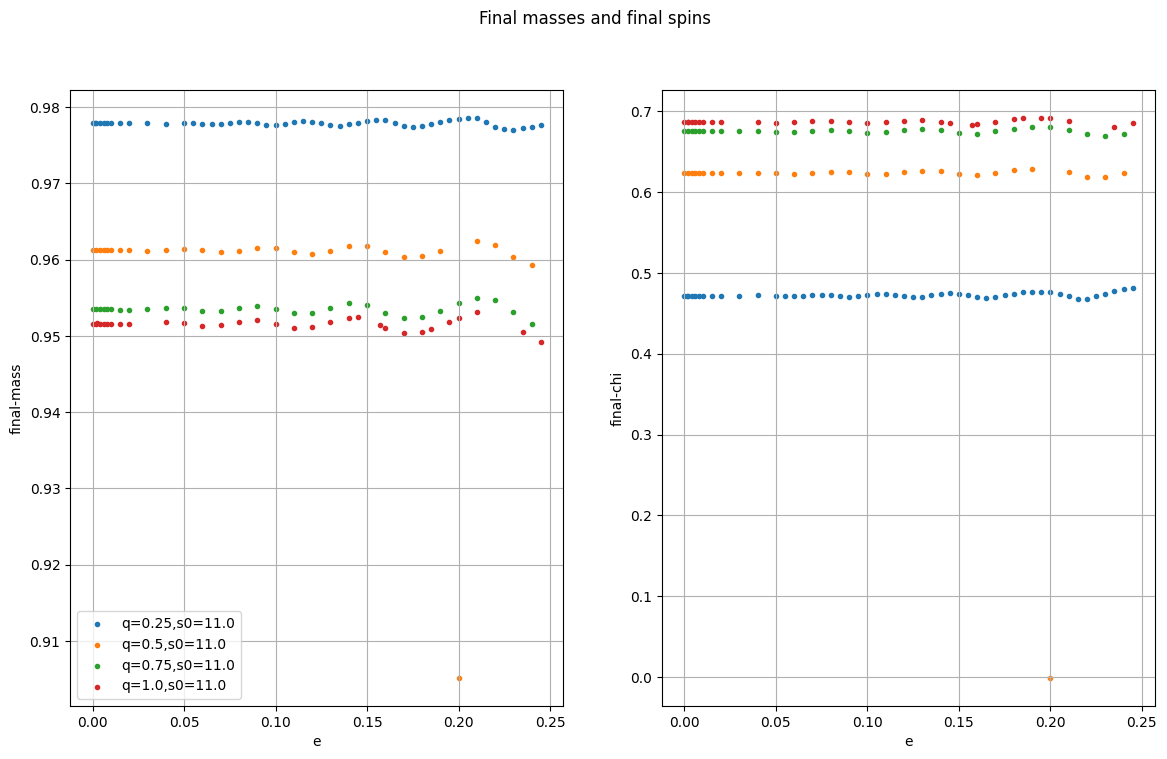

In [26]:
def oscillations_plot_final_mass_and_spin(x_name='e',y_name='final-mass',z_name='final-chi'):
    fig, axs = plt.subplots(1,2,figsize=(14,8))
    
    for sim in dense_eccentrity_sims_sep11:
        sim=sim[sim['e']<0.25]
        mass_label=str(np.unique(round(sim['q'],2))[0])
        s_label=str(np.unique(round(sim['initial-separation'],0))[0])
        axs[0].scatter(sim[x_name],sim[y_name],marker='.',label='q='+mass_label+',s0='+s_label)
        
    axs[0].set_xlabel(x_name)
    axs[0].set_ylabel(y_name)
    axs[0].grid()
    axs[0].legend(loc='best')
    for sim in dense_eccentrity_sims_sep11:
        sim=sim[sim['e']<0.25]
        mass_label=str(np.unique(round(sim['q'],2))[0])
        s_label=str(np.unique(round(sim['initial-separation'],0))[0])
        axs[1].scatter(sim[x_name],sim[z_name],marker='.',label='q='+mass_label+',s0='+s_label)
    
    axs[1].set_xlabel(x_name)
    axs[1].set_ylabel(z_name)
    axs[1].grid()
    fig.suptitle('Final masses and final spins')
    plt.savefig('final_mass-final_spin_vs_e_sep11.png')
    return

oscillations_plot_final_mass_and_spin()

## Fits to data

In [24]:
from lmfit import Model
from scipy.optimize import curve_fit

def plot_with_fit(sim,function_fit=None, guess=[0,0], x_axis='e',y_axis='final-mass'):
    
    
    sim=sim.sort_values(x_axis)
    plt0=axs.scatter(sim[x_axis], sim[y_axis],c=sim['#orbits'],marker='.')
    params, covs = curve_fit(function_fit, sim[x_axis].values , sim[y_axis].values, guess)
    print("params: ", params) 
    print("covariance: ", covs) 

    mass_label=str(np.unique(round(sim.loc[:,['q']],2))[0])
    s_label=str(np.unique(round(sim.loc[:,['initial-separation']],0))[0])
    y_ev=[function_fit(x,*params) for x in sim[x_axis].values]
    axs.plot(sim[x_axis].values, y_ev, '--', label='q='+mass_label,c='crimson')
    return

C:\Users\Emmanuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Emmanuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Emmanuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Emmanuel\AppData\Local\Packages\Pytho

params:  [ 2.50000000e-01 -3.23602808e-05  1.05772944e+01 -6.91670516e+00
  9.86792180e-01]
covariance:  [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]]
params:  [ 2.50000000e-01 -1.08851090e-04  7.70168906e+00 -6.50358573e+00
  9.81079554e-01]
covariance:  [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]]
params:  [ 2.50000000e-01 -2.00644791e-04  6.87753176e+00 -6.13283325e+00
  9.79143366e-01]
covariance:  [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]]
params:  [ 2.50000000e-01 -2.82471052e-04  6.64789696e+00 -5.83837874e+00
  9.78776434e-01]
covariance:  [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]]


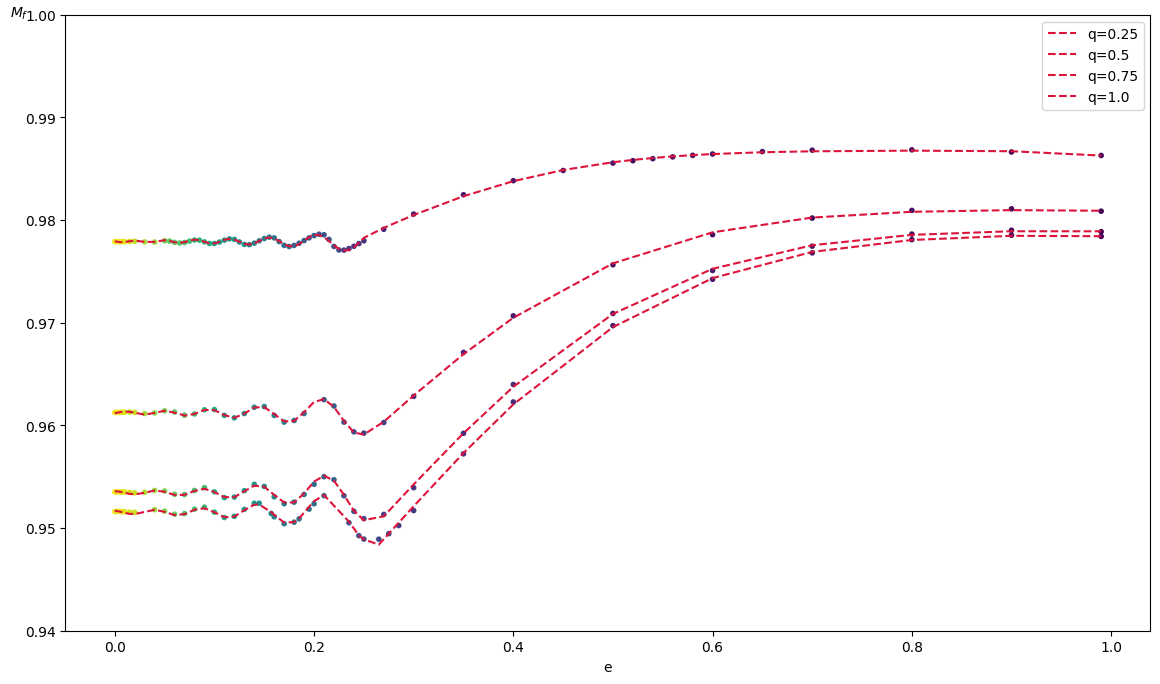

In [40]:
def poly2_damped_oscillator(t,amplitude,f1,f2,phase,decay,k):#,amplitude2,frequency2,phase2,decay2
    return amplitude*np.exp(decay*t)*np.cos(f1*t+f2*t**2 + phase)+k

list_oscillations_params=[
{'amplitude': 7.039350240594848e-05, 'f1': -240.98471453851565, 'f2': 302.5876838380385, 'phase': 86.57126385523368, 'decay': 11.03468655972541, 'k': 0.977920713653351},
{'amplitude': 0.00011556276684476378, 'f1': -172.24074906209412, 'f2': 200.373685642144, 'phase': 77.26149910009994, 'decay': 11.938111858219816, 'k': 0.9612164143611024},
{'amplitude': 0.00013150421973126322, 'f1': -156.68262408285742, 'f2': 176.47536194648444, 'phase': 75.2942858916935, 'decay': 12.065270784666023, 'k': 0.9534501933215364},
{'amplitude': 0.00014887556639812068, 'f1': -154.7170957190035, 'f2': 174.87960460832457, 'phase': 74.97462188181812, 'decay': 11.520402722919949, 'k': 0.9515427928245563}
]

fig, axs = plt.subplots(1,1,figsize=(14,8))

for i,sim in enumerate(dense_eccentrity_sims_sep11):
    
    def tmp_piecewise_function(e,x0,A,w1,phi,k1):

        oscillations_params=list_oscillations_params[i]
        if e<=x0:
            return poly2_damped_oscillator(e,**oscillations_params)
        else:
            return k1+A*np.cosh(w1*e**2+phi)

    piecewise_function_vec=np.vectorize(tmp_piecewise_function)
    guess = np.array([0.25,-2.8246e-04 ,6.64790028,-5.83840220,0.97877643])
    
    plot_with_fit(sim, function_fit=piecewise_function_vec, guess=guess)

axs.set_ylim([0.94,1])
axs.set_xlabel('e')
axs.set_ylabel('$M_f$', rotation=0, y=0.99)
plt.legend(loc='best')
plt.savefig('fit_to_final_mass.png')

## Relation between model parameters

In [16]:
from scipy.optimize import curve_fit

def poly2_damped_oscillator(t,amplitude,f1,f2,phase,decay,k):#,amplitude2,frequency2,phase2,decay2
    return amplitude*np.exp(decay*t)*np.cos(f1*t+f2*t**2 + phase)+k
#Class to 
class fitClass:
    def __init__(self):
        pass
    
    def fixed_decay_transformation(self,t,a,b,c,d):
        amplitude=self.params_to_take['amplitude']
        f1=self.params_to_take['f1']
        f2=self.params_to_take['f2']
        phase=self.params_to_take['phase']
        decay=self.params_to_take['decay']
        k=self.params_to_take['k']
        return poly2_damped_oscillator(t,amplitude*a,b*f1,c*f2,phase+d,decay,k)-self.traslation

    def fixed_phase_transformation(self,t,a,b,c,d,k2):
        amplitude=self.params_to_take['amplitude']
        f1=self.params_to_take['f1']
        f2=self.params_to_take['f2']
        phase=self.params_to_take['phase']
        decay=self.params_to_take['decay']
        k=self.params_to_take['k']
        return poly2_damped_oscillator(t,amplitude*a,b*f1,c*f2,phase,decay*d,k)+k2

### Relation between decay and mass ratio

Transformation parameters in amp,f1,f2,phase: 2.3399961018729605 0.6400664824595421 0.572611681956597 -5.3426616125188495


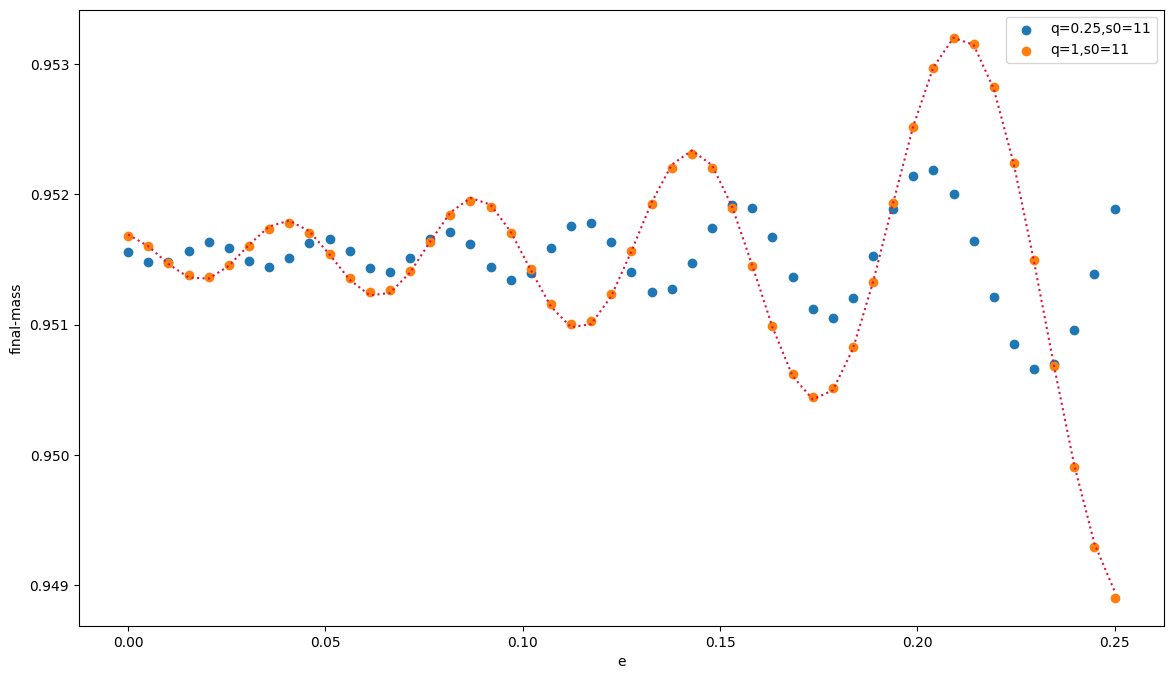

In [12]:
e_values=np.linspace(0.,0.25,50)
#
list_oscillations_params=[
{'amplitude': 7.039350240594848e-05, 'f1': -240.98471453851565, 'f2': 302.5876838380385, 'phase': 86.57126385523368, 'decay': 11.03468655972541, 'k': 0.977920713653351},#q=0.25
{'amplitude': 0.00011556276684476378, 'f1': -172.24074906209412, 'f2': 200.373685642144, 'phase': 77.26149910009994, 'decay': 11.938111858219816, 'k': 0.9612164143611024},#q=0.5
{'amplitude': 0.00013150421973126322, 'f1': -156.68262408285742, 'f2': 176.47536194648444, 'phase': 75.2942858916935, 'decay': 12.065270784666023, 'k': 0.9534501933215364},#q=0.75
{'amplitude': 0.00014887556639812068, 'f1': -154.7170957190035, 'f2': 174.87960460832457, 'phase': 74.97462188181812, 'decay': 11.520402722919949, 'k': 0.9515427928245563}#q=1
]

#Traslations between average final mass of the simulations
tras1=np.ones(len(e_values))*(list_oscillations_params[0]['k']-list_oscillations_params[3]['k'])
tras2=np.ones(len(e_values))*(list_oscillations_params[2]['k']-list_oscillations_params[3]['k'])
q025_s11_values=poly2_damped_oscillator(e_values,**list_oscillations_params[0])-tras1
q075_s11_values=poly2_damped_oscillator(e_values,**list_oscillations_params[2])-tras2
q1_s11_values=poly2_damped_oscillator(e_values,**list_oscillations_params[3])

fig, axs = plt.subplots(1,1,figsize=(14,8))
plt0=axs.scatter(e_values, q025_s11_values,label='q=0.25,s0=11')
plt2=axs.scatter(e_values, q1_s11_values,label='q=1,s0=11')

#Transformation from q=0.25 simulation to q=
q025_class=fitClass()
q025_class.params_to_take,q025_class.traslation=list_oscillations_params[0],tras1

guess = np.array([1.,1.,1.,10])
params, covs = curve_fit(q025_class.fixed_decay_transformation,e_values,q1_s11_values, guess)
print('Transformation parameters in amp,f1,f2,phase:',*params)
axs.plot(e_values, q025_class.fixed_decay_transformation(e_values,*params),c='crimson',ls='dotted')

axs.set_xlabel("e")
axs.set_ylabel("final-mass")
plt.legend()
plt.savefig('transformation_q025-to-q1.png')

### Relation between phase and initial separation

traslation parameter from q=1,s0=11 to q=1,s0=24.6: 0.026377920828794643
Transformation parameters in amp,f1,f2,phase,decay: 7.18592273894884 -0.1803741798627762 -0.2579658334137694 1.1860877852145981 0.0003912767020109882


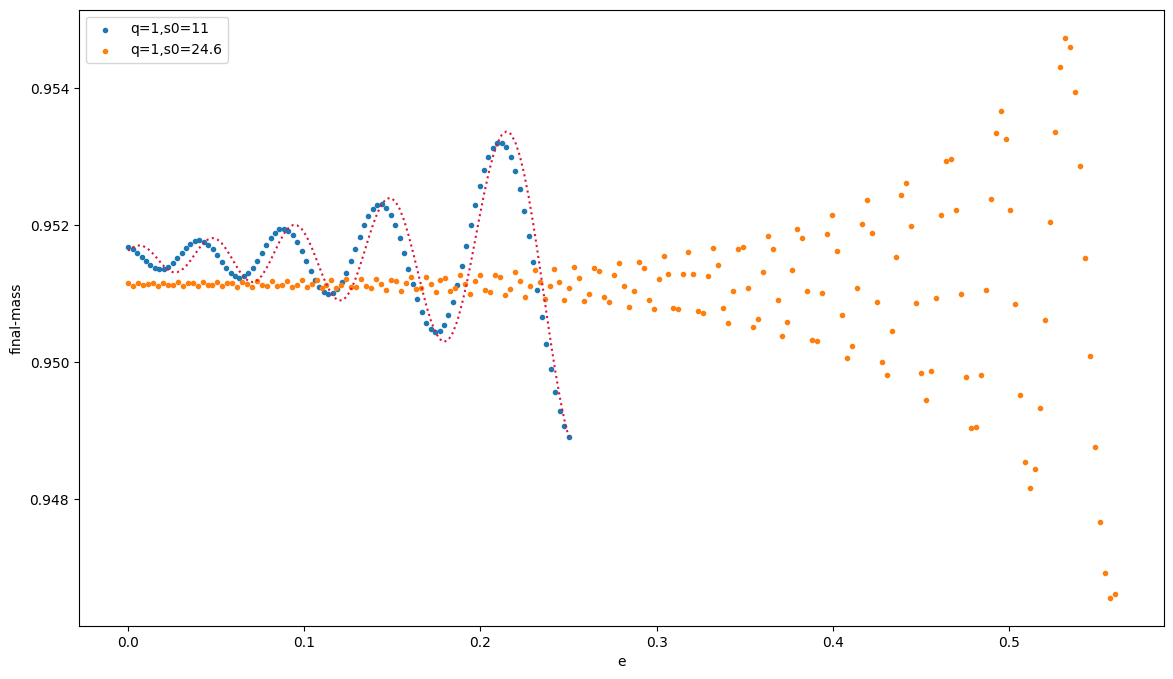

In [18]:
list_of_params=[
    {'amplitude': 0.00014887556639812068, 'f1': -154.7170957190035, 'f2': 174.87960460832457, 'phase': 74.97462188181812, 'decay': 11.520402722919949, 'k': 0.9515427928245563},#q=1,s0=11
    {'amplitude': 2.2859587083531677e-05, 'f1': 893.3339590664474, 'f2': -705.7992831938615, 'phase': -231.5315985462384, 'decay': 9.51481434964304, 'k': 0.9511402082323229}#q=1,s0=25
]
e_values_11=np.linspace(0.,0.25,100)
e_values=np.linspace(0.,0.56,200)
q1_s11_values2=poly2_damped_oscillator(e_values_11,**list_of_params[0])
q1_s11_values=poly2_damped_oscillator(e_values,**list_of_params[0])
q1_s25_values=poly2_damped_oscillator(e_values,**list_of_params[1])
# tras1=np.ones(len(e_values))*(m1o50_s11_params['k']-m1o50_s25_params['k'])

fig, axs = plt.subplots(1,1,figsize=(14,8))
print('traslation parameter from q=1,s0=11 to q=1,s0=24.6:',tras1[0])
axs.scatter(e_values_11,q1_s11_values2,marker='.',label='q=1,s0=11')
axs.scatter(e_values,q1_s25_values,marker='.',label='q=1,s0=24.6')

q1_s25_class=fitClass()
q1_s25_class.params_to_take=list_of_params[1]

guess = np.array([list_of_params[0]['amplitude']/list_of_params[1]['amplitude'],
                  list_of_params[0]['f1']/list_of_params[1]['f1'],
                  list_of_params[0]['f2']/list_of_params[1]['f2'],
                  # m1o50_s11_params['phase']-m1o50_s25_params['phase'],
                  list_of_params[0]['decay']/list_of_params[1]['decay'],
                 list_of_params[0]['k']-list_of_params[1]['k']])

params, covs = curve_fit(q1_s25_class.fixed_phase_transformation,e_values,q1_s11_values, guess)
print('Transformation parameters in amp,f1,f2,phase,decay:',*params)
axs.plot(e_values_11, q1_s25_class.fixed_phase_transformation(e_values_11,*params),c='crimson',ls='dotted')

axs.set_xlabel("e")
axs.set_ylabel("final-mass")
plt.legend()
plt.savefig('transformation_s24.5-to-11.png')

## Surrogate Model

In [ ]:
from skreducedmodel.mksurrogate import mksurrogate

surrogate = mksurrogate(parameters = param,
                        training_set = training_set,
                        physical_points = x_set,
                        )

## Model search

In [ ]:
path_real_dataset='/home/emmanuel/Dropbox/Statistics/DataAnalysis/NS_Simulations_554.dat' 
real_data = pd.read_csv(path_real_dataset)
data['q']=data['initial_m1']/data['initial_m2']
x = data[["q", "e","initial-separation","#orbits" ]] #, "initial_m2", "L0", "w022", , "peak-omega-22", "peak-ampl-22"]]
y = data[["final-mass"]]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1000)